## Отчёт по исследовательской работе по программированию (12.02.2020)

Выполнили Ковригин Александр и Панюхин Никита

Импортируем библиотеки и небольшая настройка

In [0]:
import os
import re
from typing import List, Tuple
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dataclasses import dataclass, field

from IPython.display import display
from IPython.display import set_matplotlib_formats
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
set_matplotlib_formats('svg')

Константы

In [0]:
NORM = 100000
DATA_DIRECTORY = "./data/"
FONT_SIZE = 6
DOT_SIZE = 10
COLOR_SCHEME = [
    "#0000ff",
    "#ff0000",
    "#00ff00"
]
PHRASES_FILE = "_phrases.txt"

Функция поиска фразы в тексте

In [0]:
def find(phrase: str, text: str) -> int:
    pattern = r"(\s|^)" + phrase + r"([\;\,\.\s\!\?\:\-]|$)"
    return len(re.findall(pattern, text))

Считываем файл с фразами

In [0]:
with open(os.path.join(DATA_DIRECTORY, PHRASES_FILE), "r", encoding='utf-8') as file:
    phrases = list(filter(lambda x: x, list(map(lambda x: x.strip().lower(), file.readlines()))))
phrases_count = len(phrases)

Класс результатов анализа с методами визуализации

In [0]:
@dataclass
class WordAnalysisResult:
    total_values: np.array
    target_values: np.array
    filename: str = ''
    delta: np.array = field(init=False)
    
    def __post_init__(self):
        self.delta = [abs(self.target_values[i] - self.total_values[i]) for i in range(phrases_count)]
    
    def view_as_table(self):
        nums = list(range(phrases_count))
        indexes = [y for x, y in sorted(zip(self.delta, nums), reverse=True)]
        
        data = np.array(np.array([(phrases[i],
                                   self.total_values[i],
                                   self.target_values[i],
                                   self.delta[i]) for i in indexes]))
        df = pd.DataFrame(data=data,
                          columns=['Word',
                                   'Average frequency of word occurrence (occurrences/' + str(NORM) + ' words)',
                                   'Target average frequency of word occurrence (occurrences/' + str(NORM) + ' words)',
                                   'Delta (occurrences/' + str(NORM) + ' words)'])
        df.name = 'Word occurrences difference in ' + self.filename
        display(df)
        return self
    
    def view_as_plot(self):
        def f(o):
            return [y for x, y in sorted(zip(self.delta, o))]
        sorted_total_values = f(self.total_values)
        sorted_target_values = f(self.target_values)
        sorted_phrases = f(phrases)
        
        sorted_delta = sorted(self.delta)
            
        plt.rc('font', size=FONT_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=8)     # fontsize of the x and y labels
        plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=FONT_SIZE)   # fontsize of the figure title
        
        plt.xticks(rotation=-90)
        
        plt.scatter(sorted_phrases, sorted_total_values, c=COLOR_SCHEME[0], s=DOT_SIZE).set_label('All works')
        plt.scatter(sorted_phrases, sorted_target_values, c=COLOR_SCHEME[1], s=DOT_SIZE).set_label('Target work')
        plt.scatter(sorted_phrases, sorted_delta, c=COLOR_SCHEME[2], s=DOT_SIZE).set_label('Delta')
        plt.legend(loc="center left")
        plt.show()
        return self

Обработка текстов

In [0]:
def analyze(target_file: str, exclude: List[str] = None) -> WordAnalysisResult:
    if exclude is None:
	    exclude = []
    total_text_length = 0
    target_text_length = 0
    total_values = np.full(phrases_count, 0, float)
    target_values = np.full(phrases_count, 0, float)
    
    pbar = tqdm(os.listdir(DATA_DIRECTORY))
    for filename in pbar:
        if filename == "_phrases.txt":
            continue
        pbar.set_description("Processing %s" % filename)
    
        with open(os.path.join(DATA_DIRECTORY, filename), "r", encoding='utf-8') as file:
            text = file.read().strip().lower()
    
        if filename in exclude:
            continue
        elif filename == target_file:
            target_text_length += len(text.split())
            for i in range(phrases_count):
                if text.count(phrases[i]) != 0:
                    target_values[i] += find(phrases[i], text)
        else:
            total_text_length += len(text.split())
            for i in range(phrases_count):
                if text.count(phrases[i]) != 0:
                    total_values[i] += find(phrases[i], text)

    for i in range(phrases_count):
        total_values[i] *= len(phrases[i]) * NORM / total_text_length
        target_values[i] *= len(phrases[i]) * NORM / target_text_length
    
    return WordAnalysisResult(total_values, target_values, target_file)


,Word,Average frequency of word occurrence (occurrences/100000 words),Target average frequency of word occurrence (occurrences/100000 words),Delta (occurrences/100000 words)
0,должно,91.90394335994009,143.63338256615944,51.729439206219354
1,может быть,127.64436577769456,79.04352814175441,48.60083763594015
2,наверное,104.3847257915369,61.42811329873485,42.956612492802044
3,очевидно,65.80776191205587,25.29392900536141,40.51383290669446
4,что ли,129.3462906547305,94.85223377010529,34.49405688462521
5,по всей вероятности,0.0,30.036540693866677,30.036540693866677
6,вроде,89.3510560443862,64.36401577257145,24.98704027181475
7,знать,63.82218288884728,39.521764070877204,24.300418817970076
8,как видно,71.48084483550896,48.781148796054154,22.699696039454807
9,что ль,6.807699508143711,27.10063822003008,20.29293871188637


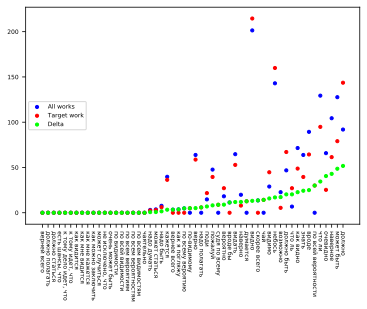

In [7]:
r1 = analyze("don.txt", exclude=["dostoevsky.txt"]).view_as_table().view_as_plot()

Посмотрим на график. Заметим, что чуть с большей/меньшей частотой встречаются слова и фразы "***может быть***", "***должно***", "***наверное***" и т.д.

Для уверенности также проверим на отличность произведение "Поднятая Целина":

,Word,Average frequency of word occurrence (occurrences/100000 words),Target average frequency of word occurrence (occurrences/100000 words),Delta (occurrences/100000 words)
0,верно,35.94148725874277,81.99524896100306,46.05376170226029
1,как видно,45.28627394601589,88.55486887788331,43.26859493186742
2,видать,38.816806239442194,81.5267046812259,42.7098984417837
3,должно быть,23.721381590770225,61.84784493058517,38.12646333981495
4,может быть,107.8244617762283,140.5632839331481,32.73882215691981
5,вероятно,0.0,29.986833905738262,29.986833905738262
6,наверное,86.25956942098264,116.19898138473576,29.939411963753116
7,поди,31.628508787693633,3.7483542382172828,27.88015454947635
8,скорее всего,0.0,22.490125429303696,22.490125429303696
9,небось,129.38935413147397,151.80834664779994,22.41899251632597


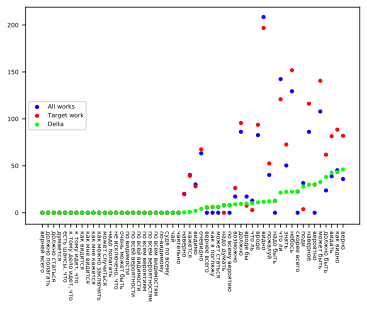

In [8]:
r2 = analyze("tselina.txt", exclude=["don.txt", "dostoevsky.txt"]).view_as_table().view_as_plot()

Видно, что распределение $\Delta$ для обоих произведений довольно близко. Хотя для "Тихого Дона" $\Delta_{max}$ всё-таки чуть больше. 

Теперь для сравнения посмотрим на совсем другого автора, например, Достоевского. Проанализируем "Преступление и Наказание".

,Word,Average frequency of word occurrence (occurrences/100000 words),Target average frequency of word occurrence (occurrences/100000 words),Delta (occurrences/100000 words)
0,может быть,127.64436577769456,987.0488796995215,859.404513921827
1,кажется,39.71158046417165,552.7473726317321,513.0357921675604
2,пожалуй,47.65389655700597,301.82915742390634,254.17526086690037
3,должно быть,46.80293411848801,194.2927794776953,147.48984535920727
4,наверно,19.855790232085823,156.36932252081894,136.51353228873313
5,вероятно,18.153865355049895,153.7718254689781,135.6179601139282
6,по-видимому,0.0,125.71885730909695,125.71885730909695
7,небось,142.96168967101792,21.818975235463107,121.14271443555481
8,видно,201.39444378258474,103.89988207363385,97.4945617089509
9,наверное,104.3847257915369,24.935971697672123,79.44875409386478


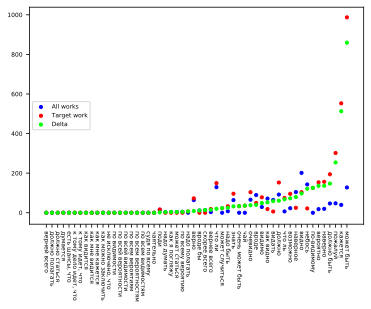

In [9]:
r3 = analyze("dostoevsky.txt", exclude=["don.txt"]).view_as_table().view_as_plot()

Если раньше $\Delta$ не превышало и 60, то теперь она бывает и под 800. Конечно, трудно попорить, что Фёдор Михайлович - совсем другой автор, но это всё равно даёт хорошее представление о работе нашего метода.

Из всего этого можно сделать вывод, что скорее всего Михаил Шолохов действительно является автором "Тихого Дона".